# Extract quadrats for GLNI samples not used in the training set

For the Limnology and Oceanography journal, extract additional training images that we didn't use yet.

- There are 921 images in GLNI
- Of these, 489 have an analysis ID (i.e., keep only those images with highest suffix). 
- Of these, 340 were not used in Train v120 (N=152).

Note that 489 - 152 = 337, so this suggests that 3 images in train set have the same analysis ID.

### To successfully extract a quadrat the algorithm assumes:

- All four corners of the quadrat are contained in the image, i.e.~the side lengths or corners are not 
cropped from the scene.

- The quadrat side lengths are not occluded, e.g., by diver equipment, mesh bags, or vegetation.

- The image is sufficiently clear, i.e.~not turbulent or cloudy from disrupted sediment.

- The camera angle is within $65-90^{\circ}$ with respect to the top surface of the quadrat.
Note that this is separate from quadrat rotation in the camera plane, which can be arbitrary.

- The camera is not too far from the quadrat such that the side lengths are less than 400 pixels 
for $1080 \times 1440$ resolution, 500 pixels for $1080 \times 1920$ HD resolution, or 400 for portrait mode in HD res.

The algorithm still works reasonably well in some cases even when the assumptions are violated, e.g., input 7 with the mesh bag covering one of the corners, as missing corner coordinates can sometimes be inferred if enough complementary lines are detected. Conversely, even when the assumptions are satisfied, a best effort is made to extract the *interior* of the quadrat, but this occaisionally won't be possible due to missing or misleading lines and part of the quadrat may be included in the output.

Prior to running this notebook you must set:

1. The `DRAW` variable annotates intermediate results on the image and is nice for visualizing results. It 
should be set to False for saving the final output.

2. The default values for all other parameters can be left as they are.

When `DRAW=True`, you will see annotations in the __Post-Processing__ pane.
- Large green circles are corner centroids found by K-means
- Medium blue circles are all line intersection points after the final stage of processing
- Small white circles are proposed crop locations (the quadrat interior corner points)
- The X lines corresponding to 'Using X of Y lines' after rejecting outliers and merging similar lines are shown in blue

Dependencies:
- `opencv.__version__==4.2.0`
- `skimage.__version__==0.16.2` 

# 1. Manual Settings
These are the only variables in the notebook user may want to change

In [13]:
# to draw lines and corners on images, helpful for debugging
DRAW = True

# run for a subset of the files
DEMO = True

# to do manual crop based on pixel range that depends only on
# resolution and portrait or landscape orientation
MANUAL_CROP = False

SAVE_PATH_SUBDIR = 'cciw/dataset_raw/quadrat-extraction/glni-1'

# 2. Begin Notebook 

No need to edit code below this point

In [2]:
import os
import os.path as osp
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = r'/content/drive/My Drive/Data'
    SAVE_PATH = osp.join(DATA_PATH, 'Quadrat_Extraction_from_Stills')

    # cd into current directory so local imports work
    %cd '/content/drive/My Drive/cciw-zebra-mussel/quadrat-extraction/'
else:
    DATA_PATH = osp.join(os.environ['DATA_PATH'], 'cciw/Data')
    SAVE_PATH = osp.join(os.environ['DATA_PATH'], SAVE_PATH_SUBDIR)
    
    if not osp.exists(SAVE_PATH):
        os.makedirs(SAVE_PATH)

print('Reading data from', DATA_PATH)
print('Saving cropped images to', SAVE_PATH)

Reading data from /media/angus/cciw/Data
Saving cropped images to /media/angus/cciw/dataset_raw/quadrat-extraction/glni-1


In [3]:
import cv2
import numpy as np

import time
from glob import glob

# local import
from utils import crop_still_image
#from utils import crop_still_image_no_rotate
from utils import compute_pairwise_distances

import matplotlib.pyplot as plt

In [4]:
def strip_filename(f):
    """
    :param f: string like '/path/to/filename.jpg'
    
    returns filename.jpg
    """
    return f.split('/')[-1]

def get_uid(f):
    """
    :param f: string like 'GLNI_{PSN}-{QUAD}_{YYY-MM-DD}_image-{SUFFIX}.jpg'
    
    returns 'GLNI_{PSN}-{QUAD}_{YYY-MM-DD}'
    """
    return f.split('_image')[0]

In [5]:
# Search for all still files in the datset
files = glob(osp.join(
    DATA_PATH, 'Videos_and_stills/GLNI/*/*/*/Images/*/*.jpg'))
print('Found %d still images' % len(files)) # 921

# sort the files in decrementing order so that
# the next cell only needs to be run once
files.sort(reverse=True)
# files

Found 921 still images


In [6]:
# only keep the images with highest suffix number (highest quality),
# which correspond to one analysis ID.

for i, f in enumerate(files):
    # get image suffix
    img_nb = int(strip_filename(f).split('.')[0].split('-')[-1])
    # check the image number
    if img_nb > 1:
        # sometimes numbers are non-contiguous
        while (img_nb - 1) > 0:
            # try to remove the image with decremented suffix
            try:
                img_path = f.split('GLNI_')[0]
                # remove the file
                files.remove(osp.join(img_path, get_uid(
                    strip_filename(f).split('.')[0]) + '_image-%d.jpg' % (img_nb - 1)))
            except:
                pass
            img_nb -= 1

print(len(files)) # 489

489


In [7]:
train_images = os.listdir(osp.join(os.environ['DATA_PATH'], 'cciw/VOCdevkit/Train-v120-originals/JPEGImages'))

In [8]:
# list to store train file unique IDs, i.e., the part of the 
# image name without the '_image-#.jpg'
train_uids = []

for i in range(len(train_images)):
    train_uids.append(get_uid(train_images[i]))

In [9]:
# store the unused training images in bonus
bonus = [f for f in files if get_uid(f.split('/')[-1]) not in train_uids]
len(bonus) # 340

340

In [10]:
# indices of data in x and y position respectively
X, Y = 0, 1

In [11]:
scale_percent = 25

s = (100 // scale_percent)

In [12]:
"""x_trim and y_trim are used to remove black padding
for 1080x1440 video which triggers spurious edges"""

"""@param canny_thresh initial hysteresis values for Canny edge 
detector, input to HoughLines"""

"""@param threshold Accumulator threshold, return 
lines with more than threshold of votes. (intersection points)"""
threshold = 125

"""@param minLineLength Minimum line length. 
Line segments shorter than that are rejected. (pixels)"""

"""@param maxLineGap Maximum allowed gap between points 
on the same line to link them. (pixels)"""

'@param maxLineGap Maximum allowed gap between points \non the same line to link them. (pixels)'

0  case 4 of 4: large resolution, landscape mode


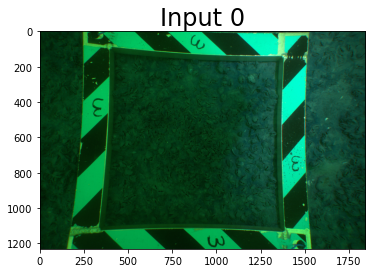

Using 9 of 11 lines
Processing took 5.11 sec


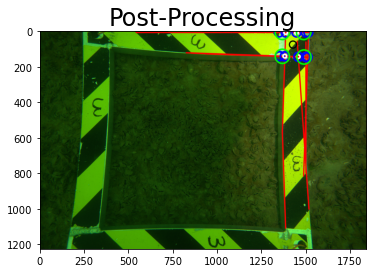

Corners do not form a square, try to crop based on two clusters
Corners too close to crop
1  case 4 of 4: large resolution, landscape mode


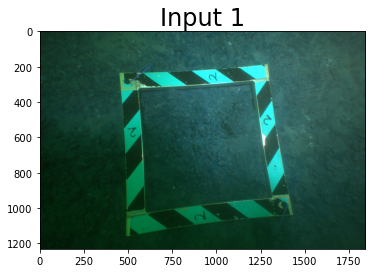

Using 10 of 14 lines
Processing took 2.69 sec


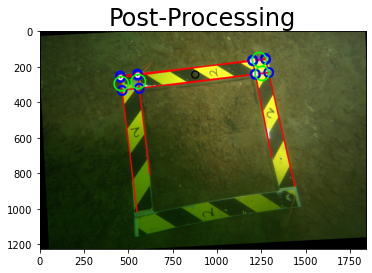

Corners do not form a square, try to crop based on two clusters
Corners too close to crop


In [14]:
mode = 0

if DEMO:
    upper_limit = 2
else:
    upper_limit = len(bonus)
    
for i in range(upper_limit):

    out_file = strip_filename(bonus[i]).split('.')[0] + '_crop.jpg'

    if osp.exists(osp.join(SAVE_PATH, out_file)):
        pass
        #continue

    # load the input image
    bgr = cv2.imread(bonus[i])
    if not MANUAL_CROP:
        bgr_orig = bgr.copy()

    # case 1 of 4: small resolution, portrait mode
    if bgr.shape[1] == 3788:
        print(i, ' case 1 of 4: small resolution, portrait mode')
        x_trim, y_trim = 100, 1200
        #x_trim, y_trim = 200, 1100
        canny_thresh1, canny_thresh2 = 10, 50
        mLL, mLG = 400, 200    
        mode = 1

    # case 2 of 4: small resolution, landscape mode
    elif bgr.shape[1] == 6738:
        print(i, ' case 2 of 4: small resolution, landscape mode')
        #x_trim, y_trim = 1000, 1
        x_trim, y_trim = 1200, 100
        canny_thresh1, canny_thresh2 = 10, 50
        mLL, mLG = 400, 200
        mode = 2

    # case 3 of 4: large resolution, portrait mode
    elif bgr.shape[1] == 4924:
        print(i, ' case 3 of 4: large resolution, portrait mode')
        x_trim, y_trim = 500, 2000
        canny_thresh1, canny_thresh2 = 10, 50
        mLL, mLG = 450, 225
        mode = 3

    # case 4 of 4: large resolution, landscape mode
    elif bgr.shape[1] == 7378:
        #x_trim, y_trim = 1100, 100 # 25% scale
        x_trim, y_trim = 2000, 500 # 100% scale
        print(i, ' case 4 of 4: large resolution, landscape mode')
        canny_thresh1, canny_thresh2 = 10, 50
        mLL, mLG = 450, 225    
        mode = 4

    if MANUAL_CROP:
        cv2.imwrite(osp.join(SAVE_PATH, out_file), bgr[y_trim:-y_trim, x_trim:-x_trim, :])
    else:
        width = int(bgr.shape[1] * scale_percent / 100)
        height = int(bgr.shape[0] * scale_percent / 100)    
        bgr = cv2.resize(bgr, (width, height)) # resize image

        plt.close('all')
        plt.figure()
        plt.imshow(bgr)
        plt.title('Input %d' % i, fontsize=24)
        plt.show()

        start_time = time.time()
        bgr, edges, crop = crop_still_image(
            bgr, mll=mLL, mlg=mLG, threshold=threshold, canny_1=canny_thresh1, canny_2=canny_thresh2, do_draw=DRAW)
        print('Processing took %.2f sec' % float(time.time() - start_time))

        plt.figure()
        plt.imshow(cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB))
        plt.title('Post-Processing', fontsize=24)
        plt.show()

        try:
            x_start = crop[:, X].min()
            x_end = crop[:, X].max()
            y_start = crop[:, Y].min()
            y_end = crop[:, Y].max()

            if (compute_pairwise_distances(crop)[:, 2] < mLL).sum():
                print('Corners do not form a square, try to crop based on two clusters')
                if mode == 2 or mode == 4:
                    centroid_y = crop[:, Y].mean()
                    d_from_y_mean = np.abs(crop[:, Y] - centroid_y)
                    crop_wrt_y = crop[np.argsort(d_from_y_mean)][:2]       
                    x_ref = int(crop_wrt_y[:, X].mean())
                    y_start = crop_wrt_y[:, Y].min()
                    y_end = crop_wrt_y[:, Y].max()
                    '''
                    centroid, crop, cluster_centers = centroid_and_crop_pts_k2means(crop)
                    # call this x_ref because we don't know if it's left or right
                    x_ref = int(crop[:, X].mean())
                    y_start = crop[:, Y].min()
                    y_end = crop[:, Y].max()
                    '''
                    delta = y_end - y_start

                    if (x_ref + delta) > bgr.shape[1]:
                        x_start = x_ref - delta
                        x_end = x_ref
                    else:
                        x_end = x_ref + delta
                        x_start = x_ref
                else:
                    centroid_x = crop[:, X].mean()
                    d_from_x_mean = np.abs(crop[:, X] - centroid_x)
                    crop_wrt_x = crop[np.argsort(d_from_x_mean)][:2]       
                    y_ref = int(crop_wrt_x[:, Y].mean())
                    x_start = crop_wrt_x[:, X].min()
                    x_end = crop_wrt_x[:, X].max()
                    '''            
                    centroid, crop, cluster_centers = centroid_and_crop_pts_k2means(crop)
                    y_ref = int(crop[:, Y].mean())
                    x_start = crop[:, X].min()
                    x_end = crop[:, X].max()
                    '''
                    # call this y_ref because we don't know if it's top or bottom
                    delta = x_end - x_start

                    if (y_ref + delta) > bgr.shape[0]:
                        y_start = y_ref - delta
                        y_end = y_ref
                    else:
                        y_end = y_ref + delta
                        y_start = y_ref

            if (y_end - y_start) > mLL and (x_end - x_start) > mLL:
                try:
                    '''
                    plt.figure()
                    plt.imshow(bgr[y_start:y_end, x_start:x_end, :])
                    '''
                    #cv2.imwrite(osp.join(SAVE_PATH, out_file), bgr[y_start:y_end, x_start:x_end, :])

                    # write a high res version
                    cv2.imwrite(osp.join(SAVE_PATH, out_file), bgr_orig[y_start * s:y_end * s, x_start * s:x_end * s, :])
                    print(i, 'SUCCESS!')
                except:
                    print('Cannot write ', out_file)
            else:
                print('Corners too close to crop')
        except:
            print('Cannot crop: insufficient number of corner points found')